# Import Necessary Packages

In [1]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit  # fit the data with a given form

In [2]:
# import the packages for symbolic regression
import sympy
import pydotplus
from IPython.display import Image
from gplearn.genetic import SymbolicRegressor
from gplearn.functions import make_function
from sympy.plotting import plot as symplot

In [3]:
# conventional machine learning method
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

In [4]:
import os
import json
from utils import createDataDic  # Self-mdae function stored in python file
from IPython.display import Image, display, Latex

# Data Preprocessing

## Getting all Dataset Path 
During this process, we use self-made function to create a dictionary to store paths of our data. The key is the parent folder name, then the child key is the file name without some nonsense postfix, lastly, the child value is the path for specific text file.

In [5]:
current_abs_path = os.path.abspath('.')  # Current absolute path
total_folder_name = 'SK_Data'
data_dic = createDataDic(current_abs_path,
                         total_folder_name)  # Data path dictionary

E:\School 4\BEng Mechanical Engineering Project\AiFeynmanTest\SK_Data\.DS_Store is a file


## Extract Data in Diffuse Model

### Simple Data Composition 
In this section, we use some simple code to give you basic idea of our data composition. The first column is the velocity, the second column is the number of molecules with correesponding velocity, the third column is the probability of correspondng velocity.

In [6]:
tan_velocity_x_path = data_dic['diffusiveWall'][
    'velocity_histogram_tangential_x']
tan_vel_name_x_list = ['vt_x', 'number', 'prob_vtx']
tan_vel_x = pd.read_csv(tan_velocity_x_path, names=tan_vel_name_x_list, 
                        header=None, sep=" ")
tan_vel_x.head(5)

,vt_x,number,prob_vtx
0,-1995,0,0.0
1,-1985,0,0.0
2,-1975,0,0.0
3,-1965,0,0.0
4,-1955,0,0.0


### Visualize the data
1. Key information for constants of methane
- kB: the Boltmann constant, 
- Tw: the temperature of the wall, 
- mi: the molecular mass of methane.
2. In this section, we plot the all probabilities in terms of different velocity components, i.e., normal velocity, tangential velocity and its magnitude. At the same time, we used the most probable speed $v_m$ to scale our velocity, where $v_m = \sqrt{\frac{2 k_B T_w}{mi}}$, so that we could gain non-dimension value here.

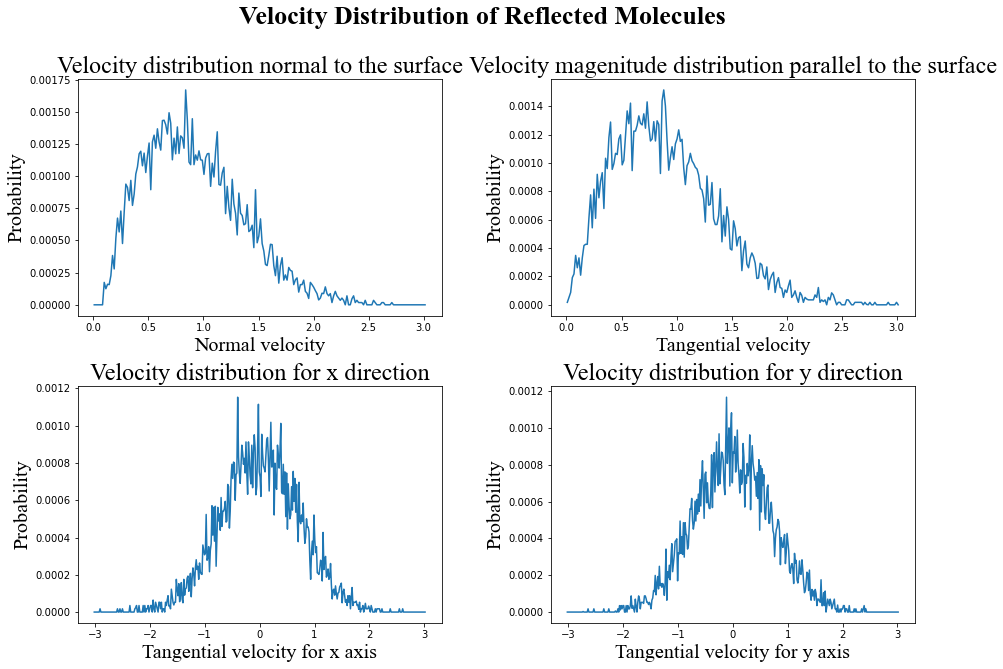

In [7]:
def extracData(folder_name, file_name):
    """
    This is a function to extract the data in corresponding file.
    Variables:
        folder_name: The name of the child folder, e.g., it is diffusiveWall here.
        file_name: The name of the file for the specific velocity
    Returns:
        v: The velocity of this text file.
        number: The number of melocules with the same velocity, v.
        prob: The probability of the velocity, v. 
    Note: All the return values have been converted to numpy ndarray.
    """
    data_path = data_dic[folder_name][file_name]  # The path of the data
    data = pd.read_csv(data_path, header=None, sep=" ")
    data_np = np.array(
        data)  # convert the data from pandas' datafframe to numpy ndarray

    # Extract the data
    v = data_np[:, 0]
    number = data_np[:, 1]
    prob = data_np[:, 2]

    return v, number, prob


def calVm(parameters):
    """
    This is the function to calculate the most probable speed for methane. 
    Variables:
        Parameters: It is a dictionary that contains the properties of gas, the
            key is the name, value is the value of corresponding constant.
            kB: Boltzman const
            Tw: Temperature of the wall
            mi: Molecular mass fof methane
    Returns:
        Vm: The most probable speed.
        Vm0: Some times could be as reference, like Vm.
    """
    kB = parameters['kB']
    Tw = parameters['Tw']
    mi = parameters['mi']

    Vm = np.sqrt(2 * kB * Tw / mi)  # Most probable speed
    Vm0 = np.sqrt(kB * Tw / mi)  # reference velocity factor

    return Vm, Vm0


gas_properties = {
    'kB': 1.38064852e-23,
    'Tw': 423,
    'mi': 2.66389e-26
}  # The corresponding parameter of methane, kB is the Boltmann constant,
# Tw is the temperature of the wall, mi is the molecular mass of methane.
Vm, _ = calVm(gas_properties)

folder_name = 'diffusiveWall'  # Fist child folder name
file_list = [
    'velocity_histogram_normal', 'velocity_histogram_tangential',
    'velocity_histogram_tangential_x', 'velocity_histogram_tangential_y'
]  # The list contains all needed file name
velocity_list = [
    'Normal velocity', 'Tangential velocity', 'Tangential velocity for x axis',
    'Tangential velocity for y axis'
]  # The list contains the different velocity component
title_list = [
    'Velocity distribution normal to the surface',
    'Velocity magenitude distribution parallel to the surface',
    'Velocity distribution for x direction',
    'Velocity distribution for y direction'
]  # The list contains all titles for the graph

font_format = {
    'family': 'Times New Roman',
    'size': 20
}  # Format dictionary for axis
title_format = {
    'family': 'Times New Roman',
    'size': 24
}  # Format dictionary for axis title
suptitle_format = {
    'family': 'Times New Roman'
}  # Format dictionary for superior title

fig = plt.figure(figsize=(15, 10))
fig.suptitle('Velocity Distribution of Reflected Molecules',
             fontdict=suptitle_format,
             fontsize=26,
             fontweight='bold') # Plot the superior title
for i, file in enumerate(file_list):
    v, _, prob = extracData(folder_name, file)
    ax = fig.add_subplot(2, 2, i + 1)
    fig.subplots_adjust(wspace=0.3, hspace=0.3)
    ax.plot(v / Vm, prob)
    ax.set_xlabel(velocity_list[i], fontdict=font_format)
    ax.set_ylabel('Probability', fontdict=font_format)
    ax.set_title(title_list[i], fontdict=title_format)

plt.savefig('./figure/diffuse_model_velocity dirstribution.png') # Save the graph

### Fit the Data for Tangential Velocity
1. In this section, we treated empirical tangentical velocity in x direction as our input data, then use curve_fit in scipy package to fit the data to check our data is satisfactory or not. Meanwhile, since we knew the mathematical expression of the corresponding scattering kernel, it is a reaaly good way to compare our fitted data with the theoretical data. Of course, empirical data, fitted data and theoretical data are all plotted in the same graph. Maybe this work could be useless at this time due to the simple scattering kernel, however, it is reaally helpful for us to get deeper of our data when encountering much more complicated scattering kernels. 
2. During analysis, we would like to use Equation \ref{eq: tangential velocity probability} to plot the theoretical value, where $V_{t, x}$ is the tangential velocity in x direction.
$$f = \frac{1}{\sqrt{\pi}v_m}\times\mathrm{exp}\left(-\frac{V_{t, x}^2}{v_m^2}\right)
\label{eq: tangential velocity probability}
$$
3. Form the printing data, we could see that the most probable speed in fitted data is 672 or 666. The reason why we have two values is that we treat the two constants in Equation \ref{eq: tangential velocity probability} to be different, in fact they should be the same. And the theoretical most probable speed is 662, which is really close to the fitted ones even with little differences. 

The size of data is (400,)
Fited parameters: A is 671.6646412844684, B is 665.7857128511228
The most probable speed for methane is 662.1686318778972.


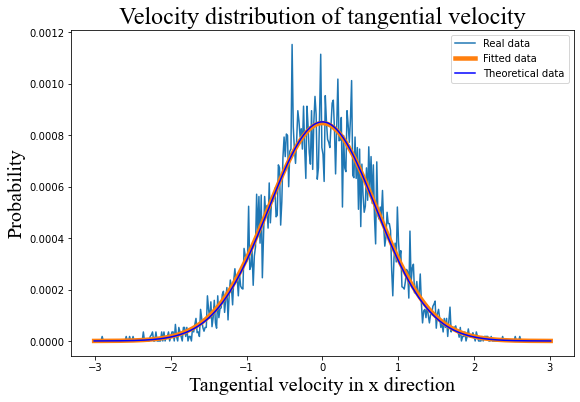

In [8]:
def fitFunction(x, A, B):
    """
    This is the helpful function inputted in the curve_fit class.
    Variables:
        x: The tangential veloocity 
        A: Fitted paprameter
        B: Fitted paprameter
    Returns:
        y: The value of the fitted function.
    """
    y = (1 / (np.sqrt(np.pi) * B)) * np.exp(-(x)**2 / np.square(A))

    return y


def theoData(x, Cm):
    """
    This is the function to calculate the theoretical value of corresponding
    scattering kernel.
    Varibales:
        x: The velocity
        Cm: The most probable speed
    Returns:
        f: The theoretical value.
    """
    # x = np.array(x)
    f = 1 / (np.sqrt(np.pi) * Cm) * np.exp(-np.power(x, 2) / Cm**2)
    print("The size of data is {}".format(f.shape))

    return f

xdata, _, ydata = extracData(folder_name, file_list[2])
f = theoData(xdata, Vm) # Theoretical line

guess = [650, 650]  # Guess value as intial searching point
parameters, covariance = curve_fit(fitFunction, xdata, ydata, p0=guess)
print('Fited parameters: A is {}, B is {}'.format(parameters[0],
                                                  parameters[1]))
print('The most probable speed for methane is {}.'.format(Vm))
fit_y = fitFunction(xdata, parameters[0], parameters[1]) # Fitted line

# Plot the graph
fig = plt.figure(figsize=(9, 6))
plt.plot(xdata / Vm, ydata, label='Real data')
plt.plot(xdata / Vm, fit_y, label='Fitted data', linewidth=4.5)
plt.plot(xdata / Vm, f, label='Theoretical data', linewidth=1.5, c='b')
plt.xlabel('Tangential velocity in x direction', fontdict=font_format)
plt.ylabel('Probability', fontdict=font_format)
plt.title('Velocity distribution of tangential velocity',
          fontdict=title_format)
plt.legend()

plt.savefig('./figure/diffuse_model_vt_x and fitted data.png')

### Prepare the data for Symbolic Regression
In this section, we define a simple function to shuffle the orignal dataset, then split it into two dataset, i.e., training one and test one. 

In [9]:
def splitDataset(X, y, ratio):
    """
    This is the function to split original empirical data, which helps get
    training dataset and test dataset.
    Variables:
        X: one dimention 
        y: one dimension
        ratio: SPlitting ratio
    Return:
        X_train: ndarray
        y_trian: ndarray
        X_test: ndarray
        y_test: ndarray
    """
    # Adding one more axis to make the data 2D
    X = X[:, np.newaxis]
    y = y[:, np.newaxis]
    dataset = np.concatenate((X, y), axis=1)
    print(type(dataset))
    print(dataset.shape)
    np.random.shuffle(dataset)
    index = int(len(X)*ratio)
    print(dataset[0])
    X_train = dataset[:index, :][:, 0]
    y_train = dataset[:index, :][:, 1]
    X_test = dataset[index:, :][:, 0]
    y_test = dataset[index:, :][:, 1]
    
    return X_train, y_train, X_test, y_test


# Spliting dataset
split_ratio = 0.8
X_train, y_train, X_test, y_test = splitDataset(xdata, ydata, split_ratio)

<class 'numpy.ndarray'>
(400, 2)
[-1145.     0.]


# Symbolic Regression

## Running Symbolic Regression
In this section, we run the symbolic regression with self-made function, thanksfully, the hyper-parameters this time could give us a good work, but for further work, I am going to establish a class or function which contain all the information together, so that we could train sepcific hyper-paramteter within a range of numer to gain the best regressor object. Of course, the constraint in the job shuld be further invextigated, which has not been done so much until now.

### Symbolic Regression Object
In this subsection, we run the code and print the mathematical symbolic expression, i.e., 
$$ f = 0.001 \times \mathrm{exp}(-x^2)
\label{eq: symbolic tangential expression}
$$
, where $x$ is the scaled tangential velocity here.
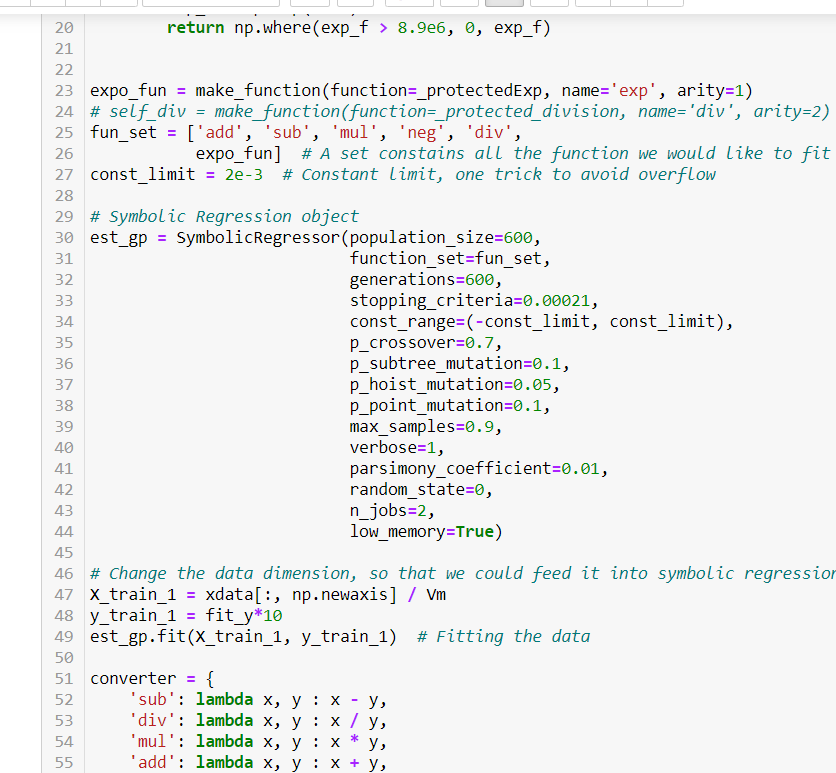

In [10]:
# self-made function
def _protected_division(x1, x2):
    """Closure of division (x1/x2) for zero denominator."""
    _EPS = 1e-10
    with np.errstate(divide='ignore', invalid='ignore'):
        abs_x2 = np.abs(x2, dtype=np.float64)
        return np.where(
            np.abs(x2) > _EPS, np.divide(x1, x2),
            np.sign(x2) * np.divide(x1, abs_x2 + _EPS))


def _protectedExp(x):
    """
    Clourse of exp for large result.
    """
    with np.errstate(divide='ignore', invalid='ignore'):
        exp_f = np.exp(x**2)
        return np.where(exp_f > 8.9e6, 0, exp_f)

In [11]:
class SelfSyblicRegression():
    """
    Create a class contains=ing all the function we need yo complement
    symbolic regression
    """
    def __init__(self, X, y, population_size, stopping_criteria, transform_ratio, const_range, prob_data):
        self.xdata = X
        self.ydata = y
        self.population = population_size
        self.stopping_criteria = stopping_criteria
        self.transform_ratio = transform_ratio
        self.const_range = const_range * transform_ratio
        self.font_format = {'family': 'Times New Roman', 'size': 16}
        self.title_format = {'family': 'Times New Roman', 'size': 20}
        self.f_fitted = prob_data['fitted']
        self.f_theo = prob_data['theo']

    def createFunSet(self):
        """
        This is the function to create function set.
        """
        expo_fun = make_function(function=_protectedExp,
                                 name='self_exp',
                                 arity=1)
        fun_set = ['add', 'sub', 'mul', 'div', 'abs', expo_fun]

        return fun_set

    def symRegression(self):
        const_limit = self.const_range
        fun_set = self.createFunSet()

        # Symbolic Regression object
        est_gp = SymbolicRegressor(population_size=self.population,
                                   function_set=fun_set,
                                   generations=600,
                                   stopping_criteria=0.002,
                                   const_range=(-const_limit, const_limit),
                                   p_crossover=0.7,
                                   p_subtree_mutation=0.1,
                                   p_hoist_mutation=0.05,
                                   p_point_mutation=0.1,
                                   max_samples=0.9,
                                   verbose=1,
                                   parsimony_coefficient=0.01,
                                   random_state=0,
                                   n_jobs=3,
                                   low_memory=True)

        return est_gp

    def printExpressionInfo(self, est_gp):
        """
        This is the function to give final information after symbolic regression,
        and the esymbolic mathematical repression will be printed out.
        """
        converter = {
            'sub': lambda x, y: x - y,
            'div': lambda x, y: x / y,
            'mul': lambda x, y: x * y,
            'add': lambda x, y: x + y,
            'neg': lambda x: -x,
            'abs': lambda x: sympy.Abs(x),
            'pow': lambda x, y: x**y,
            'sin': lambda x: sympy.sin(x),
            'cos': lambda x: sympy.cos(x),
            'inv': lambda x: 1 / x,
            'sqrt': lambda x: x**0.5,
            'self_exp': lambda x: sympy.exp(x**2),
            'square': lambda x: x**2
        }  # Converter set

        print(est_gp)
        # print('R2:', est_gp.score(X_test[:, np.newaxis], y_test))  # Give estimation score
        next_e = sympy.sympify(str(est_gp._program), locals=converter) / self.transform_ratio
        print('Expression:', next_e)

        return next_e 

    def plotGraph(self, est_gp):
        """
        This is the function to plot the subtree structured individual
        Variables:
            est_gp: symbolic regressior after fitting
        """
        graph = est_gp._program.export_graphviz()
        graph = pydotplus.graphviz.graph_from_dot_data(graph)
        img = Image(graph.create_png())
        display(img)

    def plotProb(self, next_e):
        """
        This is the function to plot the trend of probablity along the normal
        velocity.
        """
        xlimit_upper = self.xdata.max()
        xlimit_lower = self.xdata.min()
        # symplot(next_e, xlim=[-3, 3], adaptive=False, nb_of_points=400)
        symplot(next_e, xlim=[xlimit_lower, xlimit_upper], adaptive=False, nb_of_points=400)

    def calIntegration(self, next_e):
        """
        next_e: 
        """
        x = sympy.symbols('X0')
        sympy.init_printing(use_unicode=True)

        next_e_new = next_e.subs(x, x / Vm) 
        # Set the integration limit
        lower_limit = -sympy.oo
        upper_limit = sympy.oo
        int1 = sympy.Integral(next_e_new, (x, lower_limit, upper_limit))
        display(
            Latex(
                f"$${sympy.latex(int1)} = {sympy.latex(int1.doit())} = {sympy.latex(int1.doit().evalf(6))}$$"
            ))
        
        return int1.doit().evalf(6)

    def plotComparisonNormal(self, next_e, path):
        """
        Variables:
            next_e: Symbolic expression
            path: File path stored picture
        """
        X0 = sympy.symbols('X0')  # Create the symbols object
        x_scale_list = self.xdata
        est_value = [next_e.subs({X0: value}) for value in x_scale_list]

        # Plot the graph
        fig = plt.figure(figsize=(12, 6))
        plt.plot(x_scale_list, self.ydata, label='Real data')
        plt.plot(x_scale_list, self.f_fitted, label='Fitted data', linewidth=4.5,
                 c='g', alpha=0.8)
        plt.plot(x_scale_list, self.f_theo, label='Theoretical data', linewidth=3.5,
                 c='b')
        plt.plot(x_scale_list, est_value, label='Symboic Regression data', linewidth=2,
                 c='r')
        plt.xlabel('Normal velocity', fontdict=self.font_format)
        plt.ylabel('Probability', fontdict=self.font_format)
        plt.title('Velocity distribution of normal velocity',
                  fontdict=self.title_format)
        plt.legend()
        plt.show()

        plt.savefig(path)

    def run(self):
        """
        This is the main function that help us run the whole symbolic regression.
        """
        # 1. Create estimation object of gplearn
        est_gp = self.symRegression()

        # Change the data dimension, so that we could feed it into symbolic regression ovject.
        X_train_1 = self.xdata[:, np.newaxis]
        y_train_1 = self.ydata * self.transform_ratio

        # 2. Fit the data
        est_gp.fit(X_train_1, y_train_1)

        # 3. Print expression
        print('-' * 50, 'INFO', '-' * 50)
        print('-'*30, 'Popupation:{}, Stopping Cretia:{}'.format(self.population, self.stopping_criteria))
        next_e = self.printExpressionInfo(est_gp)  # symbolic expression

        # 4. Plot Graph
        print('-' * 50, 'SUBTREE', '-' * 50)
        self.plotGraph(est_gp)

        # 5. Plot probability
        print('-' * 50, 'PROBABILITY', '-' * 50)
        self.plotProb(next_e)

        return next_e

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    23.70      5.97529e+10       25        0.0021928       0.00260838     18.19m
   1     9.05          1041.02        9      0.000451086      0.000368311      4.50m
-------------------------------------------------- INFO --------------------------------------------------
------------------------------ Popupation:1100, Stopping Cretia:2e-05
div(add(mul(0.019, -0.001), abs(0.009)), self_exp(X0))
Expression: 0.0008981*exp(-X0**2)
-------------------------------------------------- SUBTREE --------------------------------------------------


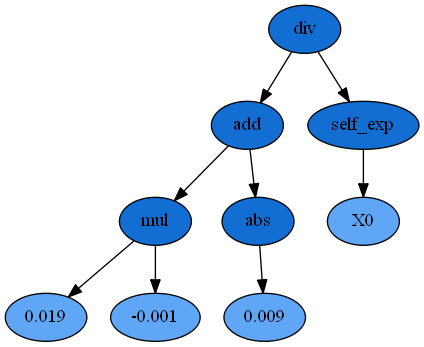

-------------------------------------------------- PROBABILITY --------------------------------------------------


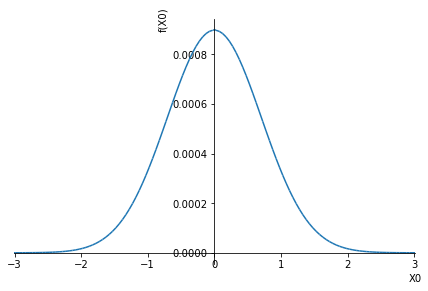

<IPython.core.display.Latex object>

1.05407


In [12]:
xdata_1 = xdata / Vm  # Normaliza the data
trans_ratio = 10
prob_data = {'fitted': fit_y, 'theo': f}
symbolic_object = SelfSyblicRegression(xdata_1,
                                       ydata,
                                       population_size=1100,
                                       stopping_criteria=0.00002,
                                       transform_ratio=trans_ratio,
                                       const_range=2e-3,
                                       prob_data=prob_data)
next_e = symbolic_object.run()
value = symbolic_object.calIntegration(next_e)
print(value)

In [13]:
x = sympy.symbols('X0')
sympy.init_printing(use_unicode=True)

next_e_new = next_e.subs(x, x/Vm)
# Set the integration limit
lower_limit = -sympy.oo
upper_limit = sympy.oo
int1 = sympy.Integral(next_e_new, (x, lower_limit, upper_limit))
display(Latex(f"$${sympy.latex(int1)} = {sympy.latex(int1.doit())} = {sympy.latex(int1.doit().evalf(6))}$$"))

<IPython.core.display.Latex object>

In [ ]:
next_e

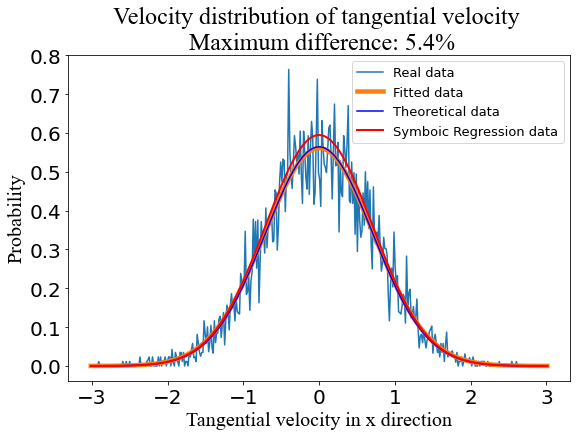

In [14]:
X0 = sympy.symbols('X0')  # Create the symbols object
x_scale_list = xdata/Vm
est_value = [next_e.subs({X0:value}) for value in x_scale_list] 

# Plot the graph 
fig = plt.figure(figsize=(9, 6))
plt.plot(xdata / Vm, ydata*Vm, label='Real data')
plt.plot(xdata / Vm, fit_y*Vm, label='Fitted data', linewidth=4.5)
plt.plot(xdata / Vm, f*Vm, label='Theoretical data', linewidth=1.5, c='b')
plt.plot(x_scale_list, est_value*np.array(Vm), label='Symboic Regression data', linewidth=2, c='r')
plt.xlabel('Tangential velocity in x direction', fontdict=font_format)
plt.ylabel('Probability', fontdict=font_format)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Find the maximum difference
difference_array = est_value*np.array(Vm) - f*Vm
index = np.argmax(difference_array)
max_diff = difference_array[index] / (f[index]*Vm) * 100 # It should be 100 percent
        
plt.title('Velocity distribution of tangential velocity \n Maximum difference: {:.2}%'.format(max_diff),
          fontdict=title_format)
plt.legend(fontsize=13)

plt.savefig('./figure/diffuse_model_vt_x and symbolic regression data.png')

### Loop

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    23.13      5.86628e+07        5       0.00234327       0.00261775      2.18m
   1     8.00          1043.68        5      0.000817801       0.00115724      2.51m
-------------------------------------------------- INFO --------------------------------------------------
------------------------------ Popupation:600, Stopping Cretia:1e-07
div(abs(0.011), self_exp(X0))
Expression: 0.0011*exp(-X0**2)
-------------------------------------------------- SUBTREE --------------------------------------------------


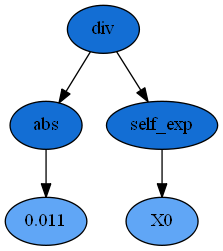

-------------------------------------------------- PROBABILITY --------------------------------------------------


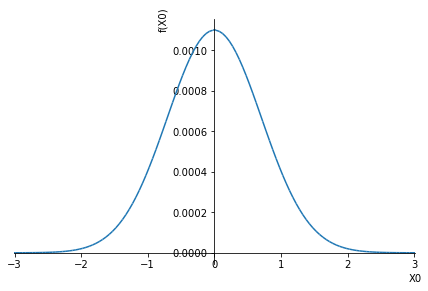

<IPython.core.display.Latex object>

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    23.13      5.86628e+07        5       0.00234327       0.00261775      2.22m
   1     8.00          1043.68        5      0.000817801       0.00115724      2.59m
-------------------------------------------------- INFO --------------------------------------------------
------------------------------ Popupation:600, Stopping Cretia:5e-07
div(abs(0.011), self_exp(X0))
Expression: 0.0011*exp(-X0**2)
-------------------------------------------------- SUBTREE --------------------------------------------------


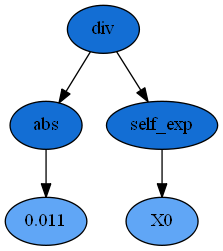

-------------------------------------------------- PROBABILITY --------------------------------------------------


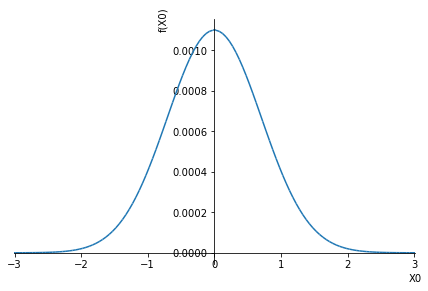

<IPython.core.display.Latex object>

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    23.13      5.86628e+07        5       0.00234327       0.00261775      2.06m
   1     8.00          1043.68        5      0.000817801       0.00115724      2.60m
-------------------------------------------------- INFO --------------------------------------------------
------------------------------ Popupation:600, Stopping Cretia:1e-06
div(abs(0.011), self_exp(X0))
Expression: 0.0011*exp(-X0**2)
-------------------------------------------------- SUBTREE --------------------------------------------------


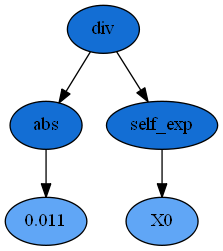

-------------------------------------------------- PROBABILITY --------------------------------------------------


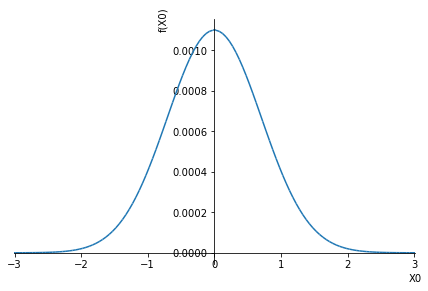

<IPython.core.display.Latex object>

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    23.13      5.86628e+07        5       0.00234327       0.00261775      2.10m
   1     8.00          1043.68        5      0.000817801       0.00115724      2.54m
-------------------------------------------------- INFO --------------------------------------------------
------------------------------ Popupation:600, Stopping Cretia:5e-06
div(abs(0.011), self_exp(X0))
Expression: 0.0011*exp(-X0**2)
-------------------------------------------------- SUBTREE --------------------------------------------------


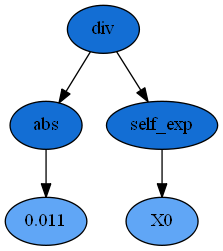

-------------------------------------------------- PROBABILITY --------------------------------------------------


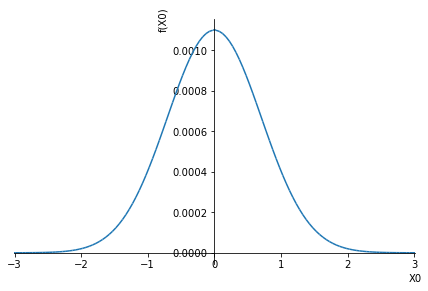

<IPython.core.display.Latex object>

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    23.13      5.86628e+07        5       0.00234327       0.00261775      2.14m
   1     8.00          1043.68        5      0.000817801       0.00115724      2.41m
-------------------------------------------------- INFO --------------------------------------------------
------------------------------ Popupation:600, Stopping Cretia:1e-05
div(abs(0.011), self_exp(X0))
Expression: 0.0011*exp(-X0**2)
-------------------------------------------------- SUBTREE --------------------------------------------------


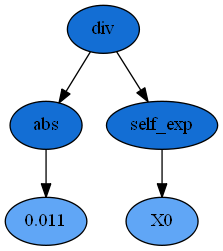

-------------------------------------------------- PROBABILITY --------------------------------------------------


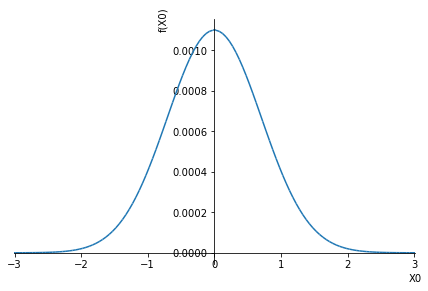

<IPython.core.display.Latex object>

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    23.13      5.86628e+07        5       0.00234327       0.00261775      2.10m
   1     8.00          1043.68        5      0.000817801       0.00115724      2.58m
-------------------------------------------------- INFO --------------------------------------------------
------------------------------ Popupation:600, Stopping Cretia:5e-05
div(abs(0.011), self_exp(X0))
Expression: 0.0011*exp(-X0**2)
-------------------------------------------------- SUBTREE --------------------------------------------------


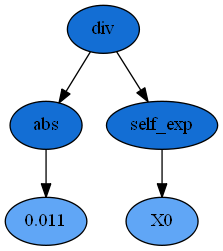

-------------------------------------------------- PROBABILITY --------------------------------------------------


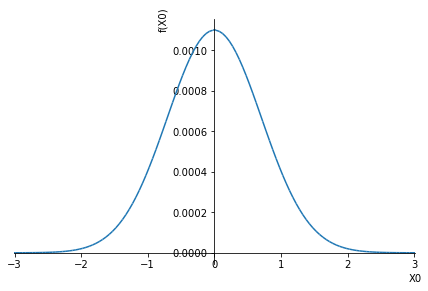

<IPython.core.display.Latex object>

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    23.13      5.86628e+07        5       0.00234327       0.00261775      2.13m
   1     8.00          1043.68        5      0.000817801       0.00115724      2.46m
-------------------------------------------------- INFO --------------------------------------------------
------------------------------ Popupation:600, Stopping Cretia:0.0001
div(abs(0.011), self_exp(X0))
Expression: 0.0011*exp(-X0**2)
-------------------------------------------------- SUBTREE --------------------------------------------------


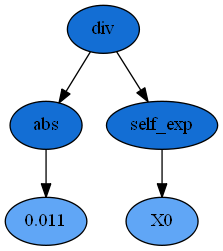

-------------------------------------------------- PROBABILITY --------------------------------------------------


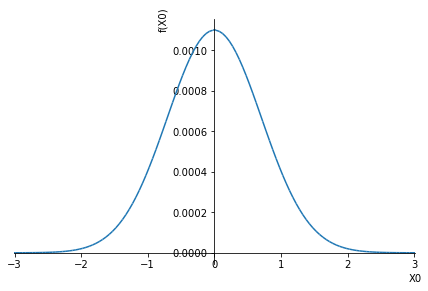

<IPython.core.display.Latex object>

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    23.13      5.86628e+07        5       0.00234327       0.00261775      2.22m
   1     8.00          1043.68        5      0.000817801       0.00115724      2.52m
-------------------------------------------------- INFO --------------------------------------------------
------------------------------ Popupation:600, Stopping Cretia:0.0005
div(abs(0.011), self_exp(X0))
Expression: 0.0011*exp(-X0**2)
-------------------------------------------------- SUBTREE --------------------------------------------------


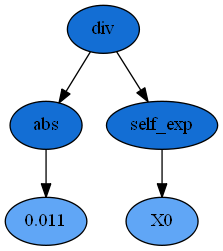

-------------------------------------------------- PROBABILITY --------------------------------------------------


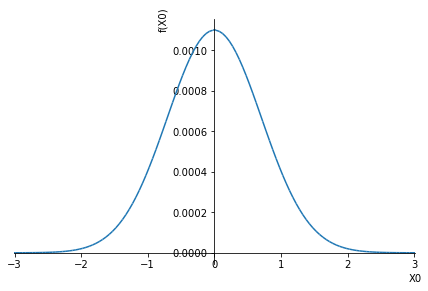

<IPython.core.display.Latex object>

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    23.13      5.86628e+07        5       0.00234327       0.00261775      2.09m
   1     8.00          1043.68        5      0.000817801       0.00115724      2.66m
-------------------------------------------------- INFO --------------------------------------------------
------------------------------ Popupation:600, Stopping Cretia:0.001
div(abs(0.011), self_exp(X0))
Expression: 0.0011*exp(-X0**2)
-------------------------------------------------- SUBTREE --------------------------------------------------


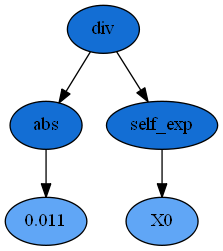

-------------------------------------------------- PROBABILITY --------------------------------------------------


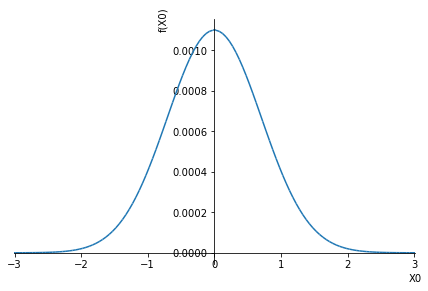

<IPython.core.display.Latex object>

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    23.13      5.86628e+07        5       0.00234327       0.00261775      2.16m
   1     8.00          1043.68        5      0.000817801       0.00115724      2.61m
-------------------------------------------------- INFO --------------------------------------------------
------------------------------ Popupation:600, Stopping Cretia:0.005
div(abs(0.011), self_exp(X0))
Expression: 0.0011*exp(-X0**2)
-------------------------------------------------- SUBTREE --------------------------------------------------


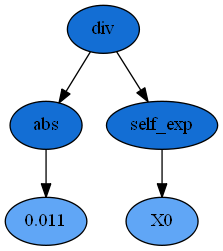

-------------------------------------------------- PROBABILITY --------------------------------------------------


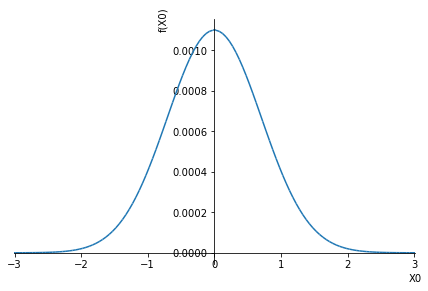

<IPython.core.display.Latex object>

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    23.13      5.86628e+07        5       0.00234327       0.00261775      2.22m
   1     8.00          1043.68        5      0.000817801       0.00115724      2.70m
-------------------------------------------------- INFO --------------------------------------------------
------------------------------ Popupation:600, Stopping Cretia:0.01
div(abs(0.011), self_exp(X0))
Expression: 0.0011*exp(-X0**2)
-------------------------------------------------- SUBTREE --------------------------------------------------


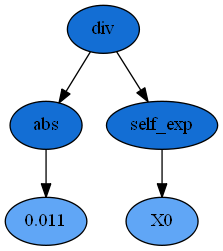

-------------------------------------------------- PROBABILITY --------------------------------------------------


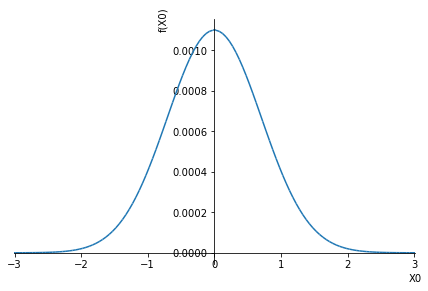

<IPython.core.display.Latex object>

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    23.21      5.41959e+07        5       0.00234327       0.00261775      2.38m
   1     8.24          872.205        7      0.000867107      0.000713483      2.80m
-------------------------------------------------- INFO --------------------------------------------------
------------------------------ Popupation:650, Stopping Cretia:1e-07
div(abs(abs(abs(0.011))), self_exp(X0))
Expression: 0.0011*exp(-X0**2)
-------------------------------------------------- SUBTREE --------------------------------------------------


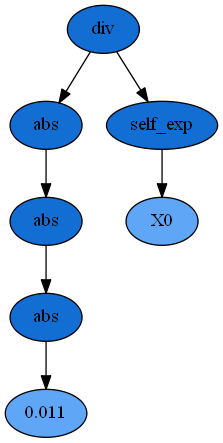

-------------------------------------------------- PROBABILITY --------------------------------------------------


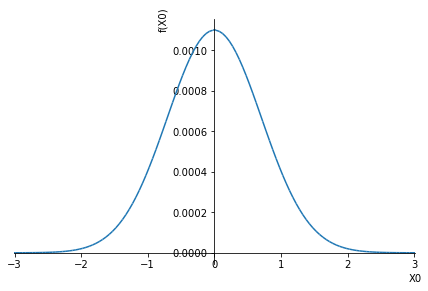

<IPython.core.display.Latex object>

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    23.21      5.41959e+07        5       0.00234327       0.00261775      2.40m
   1     8.24          872.205        7      0.000867107      0.000713483      2.66m
-------------------------------------------------- INFO --------------------------------------------------
------------------------------ Popupation:650, Stopping Cretia:5e-07
div(abs(abs(abs(0.011))), self_exp(X0))
Expression: 0.0011*exp(-X0**2)
-------------------------------------------------- SUBTREE --------------------------------------------------


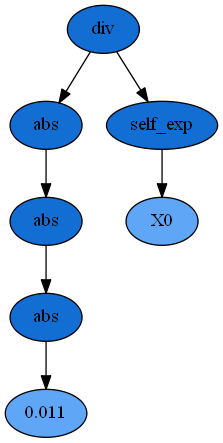

-------------------------------------------------- PROBABILITY --------------------------------------------------


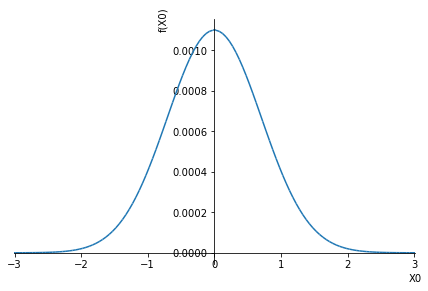

<IPython.core.display.Latex object>

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    23.21      5.41959e+07        5       0.00234327       0.00261775      2.27m
   1     8.24          872.205        7      0.000867107      0.000713483      2.81m
-------------------------------------------------- INFO --------------------------------------------------
------------------------------ Popupation:650, Stopping Cretia:1e-06
div(abs(abs(abs(0.011))), self_exp(X0))
Expression: 0.0011*exp(-X0**2)
-------------------------------------------------- SUBTREE --------------------------------------------------


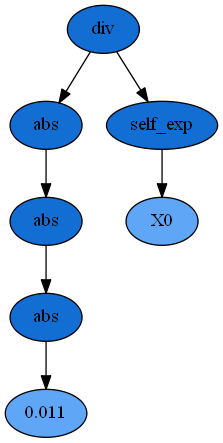

-------------------------------------------------- PROBABILITY --------------------------------------------------


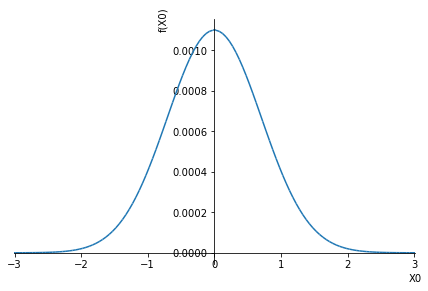

<IPython.core.display.Latex object>

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    23.21      5.41959e+07        5       0.00234327       0.00261775      2.28m
   1     8.24          872.205        7      0.000867107      0.000713483      2.64m
-------------------------------------------------- INFO --------------------------------------------------
------------------------------ Popupation:650, Stopping Cretia:5e-06
div(abs(abs(abs(0.011))), self_exp(X0))
Expression: 0.0011*exp(-X0**2)
-------------------------------------------------- SUBTREE --------------------------------------------------


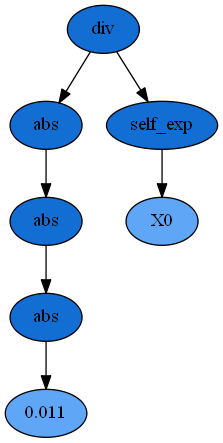

-------------------------------------------------- PROBABILITY --------------------------------------------------


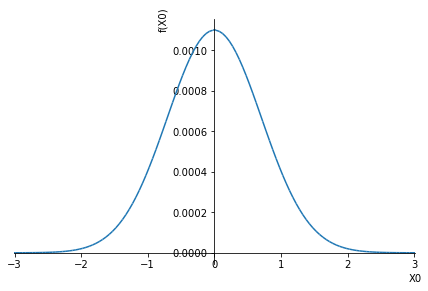

<IPython.core.display.Latex object>

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    23.21      5.41959e+07        5       0.00234327       0.00261775      2.28m
   1     8.24          872.205        7      0.000867107      0.000713483      2.69m
-------------------------------------------------- INFO --------------------------------------------------
------------------------------ Popupation:650, Stopping Cretia:1e-05
div(abs(abs(abs(0.011))), self_exp(X0))
Expression: 0.0011*exp(-X0**2)
-------------------------------------------------- SUBTREE --------------------------------------------------


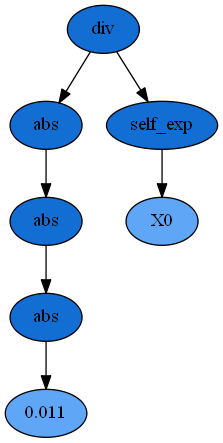

-------------------------------------------------- PROBABILITY --------------------------------------------------


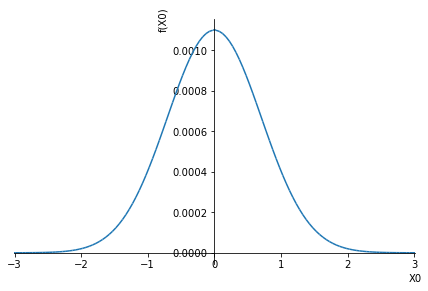

<IPython.core.display.Latex object>

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    23.21      5.41959e+07        5       0.00234327       0.00261775      2.23m
   1     8.24          872.205        7      0.000867107      0.000713483      2.66m
-------------------------------------------------- INFO --------------------------------------------------
------------------------------ Popupation:650, Stopping Cretia:5e-05
div(abs(abs(abs(0.011))), self_exp(X0))
Expression: 0.0011*exp(-X0**2)
-------------------------------------------------- SUBTREE --------------------------------------------------


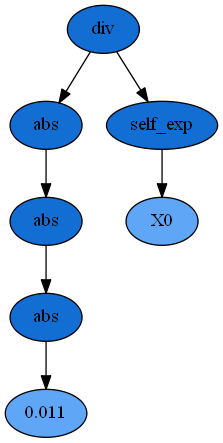

-------------------------------------------------- PROBABILITY --------------------------------------------------


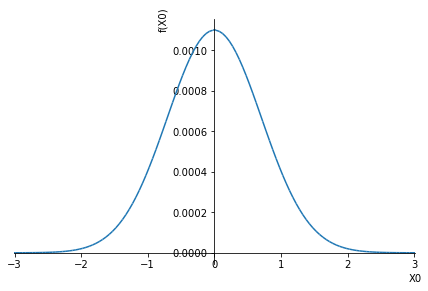

<IPython.core.display.Latex object>

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    23.21      5.41959e+07        5       0.00234327       0.00261775      2.26m
   1     8.24          872.205        7      0.000867107      0.000713483      2.76m
-------------------------------------------------- INFO --------------------------------------------------
------------------------------ Popupation:650, Stopping Cretia:0.0001
div(abs(abs(abs(0.011))), self_exp(X0))
Expression: 0.0011*exp(-X0**2)
-------------------------------------------------- SUBTREE --------------------------------------------------


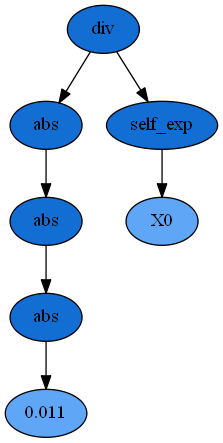

-------------------------------------------------- PROBABILITY --------------------------------------------------


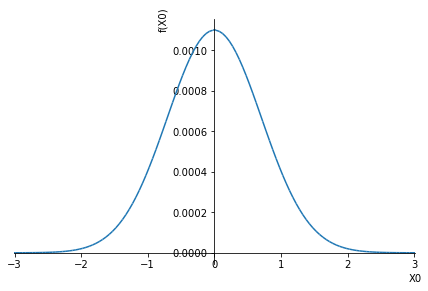

<IPython.core.display.Latex object>

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    23.21      5.41959e+07        5       0.00234327       0.00261775      2.22m
   1     8.24          872.205        7      0.000867107      0.000713483      2.60m
-------------------------------------------------- INFO --------------------------------------------------
------------------------------ Popupation:650, Stopping Cretia:0.0005
div(abs(abs(abs(0.011))), self_exp(X0))
Expression: 0.0011*exp(-X0**2)
-------------------------------------------------- SUBTREE --------------------------------------------------


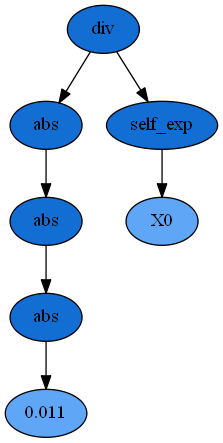

-------------------------------------------------- PROBABILITY --------------------------------------------------


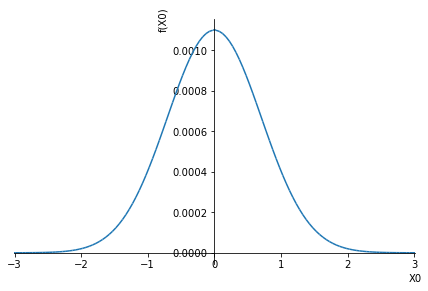

<IPython.core.display.Latex object>

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    23.21      5.41959e+07        5       0.00234327       0.00261775      2.36m
   1     8.24          872.205        7      0.000867107      0.000713483      2.63m
-------------------------------------------------- INFO --------------------------------------------------
------------------------------ Popupation:650, Stopping Cretia:0.001
div(abs(abs(abs(0.011))), self_exp(X0))
Expression: 0.0011*exp(-X0**2)
-------------------------------------------------- SUBTREE --------------------------------------------------


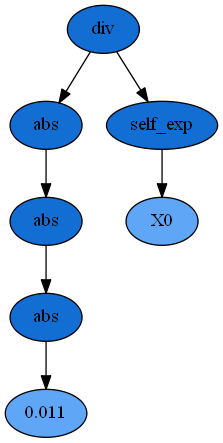

-------------------------------------------------- PROBABILITY --------------------------------------------------


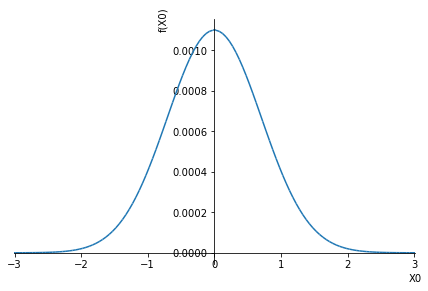

<IPython.core.display.Latex object>

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    23.21      5.41959e+07        5       0.00234327       0.00261775      2.29m
   1     8.24          872.205        7      0.000867107      0.000713483      2.66m
-------------------------------------------------- INFO --------------------------------------------------
------------------------------ Popupation:650, Stopping Cretia:0.005
div(abs(abs(abs(0.011))), self_exp(X0))
Expression: 0.0011*exp(-X0**2)
-------------------------------------------------- SUBTREE --------------------------------------------------


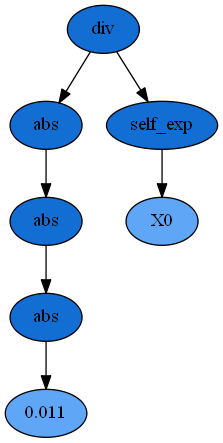

-------------------------------------------------- PROBABILITY --------------------------------------------------


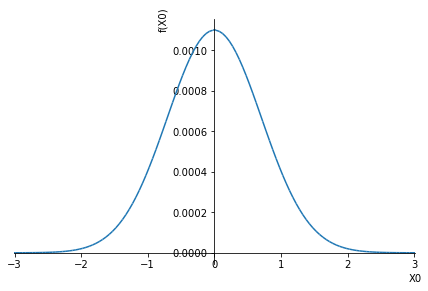

<IPython.core.display.Latex object>

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    23.21      5.41959e+07        5       0.00234327       0.00261775      2.27m
   1     8.24          872.205        7      0.000867107      0.000713483      2.65m
-------------------------------------------------- INFO --------------------------------------------------
------------------------------ Popupation:650, Stopping Cretia:0.01
div(abs(abs(abs(0.011))), self_exp(X0))
Expression: 0.0011*exp(-X0**2)
-------------------------------------------------- SUBTREE --------------------------------------------------


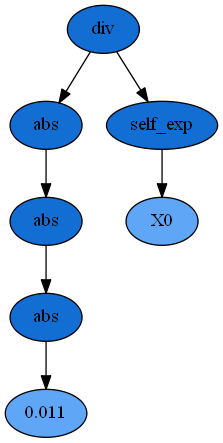

-------------------------------------------------- PROBABILITY --------------------------------------------------


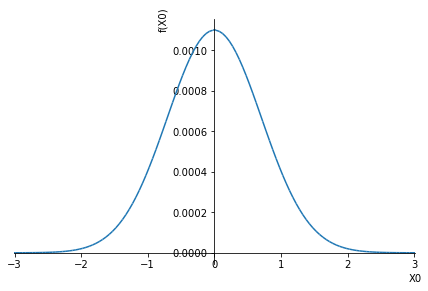

<IPython.core.display.Latex object>

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    23.45      3.26593e+09        5       0.00234327       0.00261775      2.43m
   1     8.35          1360.02        5       0.00127607       0.00122523      2.99m
-------------------------------------------------- INFO --------------------------------------------------
------------------------------ Popupation:700, Stopping Cretia:1e-07
div(abs(0.004), self_exp(X0))
Expression: 0.0004*exp(-X0**2)
-------------------------------------------------- SUBTREE --------------------------------------------------


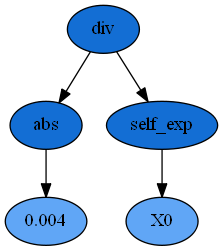

-------------------------------------------------- PROBABILITY --------------------------------------------------


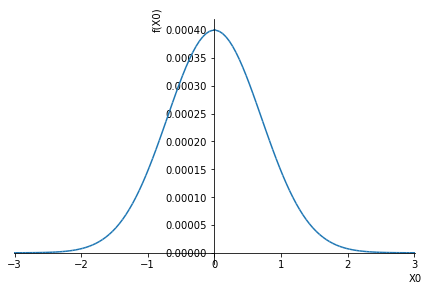

<IPython.core.display.Latex object>

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    23.45      3.26593e+09        5       0.00234327       0.00261775      2.39m
   1     8.35          1360.02        5       0.00127607       0.00122523      2.87m
-------------------------------------------------- INFO --------------------------------------------------
------------------------------ Popupation:700, Stopping Cretia:5e-07
div(abs(0.004), self_exp(X0))
Expression: 0.0004*exp(-X0**2)
-------------------------------------------------- SUBTREE --------------------------------------------------


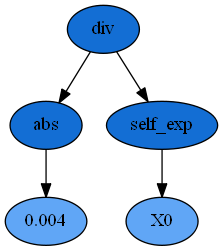

-------------------------------------------------- PROBABILITY --------------------------------------------------


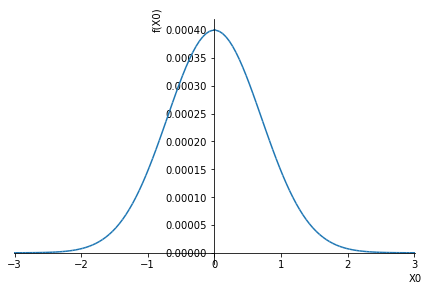

<IPython.core.display.Latex object>

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    23.45      3.26593e+09        5       0.00234327       0.00261775      2.48m
   1     8.35          1360.02        5       0.00127607       0.00122523      2.88m
-------------------------------------------------- INFO --------------------------------------------------
------------------------------ Popupation:700, Stopping Cretia:1e-06
div(abs(0.004), self_exp(X0))
Expression: 0.0004*exp(-X0**2)
-------------------------------------------------- SUBTREE --------------------------------------------------


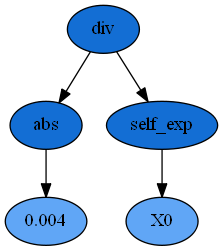

-------------------------------------------------- PROBABILITY --------------------------------------------------


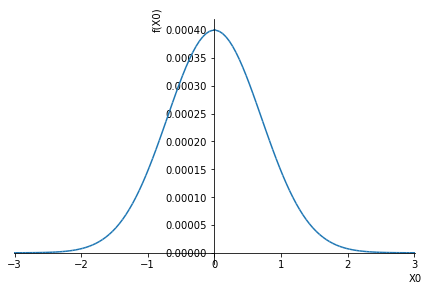

<IPython.core.display.Latex object>

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    23.45      3.26593e+09        5       0.00234327       0.00261775      2.43m
   1     8.35          1360.02        5       0.00127607       0.00122523      2.85m
-------------------------------------------------- INFO --------------------------------------------------
------------------------------ Popupation:700, Stopping Cretia:5e-06
div(abs(0.004), self_exp(X0))
Expression: 0.0004*exp(-X0**2)
-------------------------------------------------- SUBTREE --------------------------------------------------


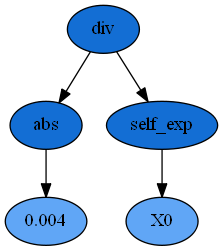

-------------------------------------------------- PROBABILITY --------------------------------------------------


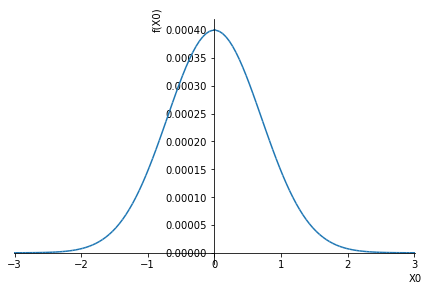

<IPython.core.display.Latex object>

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    23.45      3.26593e+09        5       0.00234327       0.00261775      2.37m
   1     8.35          1360.02        5       0.00127607       0.00122523      2.80m
-------------------------------------------------- INFO --------------------------------------------------
------------------------------ Popupation:700, Stopping Cretia:1e-05
div(abs(0.004), self_exp(X0))
Expression: 0.0004*exp(-X0**2)
-------------------------------------------------- SUBTREE --------------------------------------------------


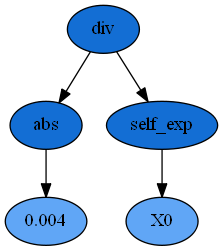

-------------------------------------------------- PROBABILITY --------------------------------------------------


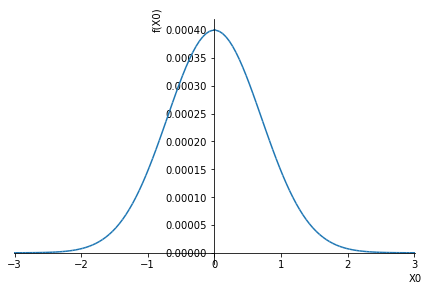

<IPython.core.display.Latex object>

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    23.45      3.26593e+09        5       0.00234327       0.00261775      2.44m
   1     8.35          1360.02        5       0.00127607       0.00122523      2.82m
-------------------------------------------------- INFO --------------------------------------------------
------------------------------ Popupation:700, Stopping Cretia:5e-05
div(abs(0.004), self_exp(X0))
Expression: 0.0004*exp(-X0**2)
-------------------------------------------------- SUBTREE --------------------------------------------------


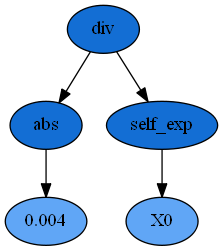

-------------------------------------------------- PROBABILITY --------------------------------------------------


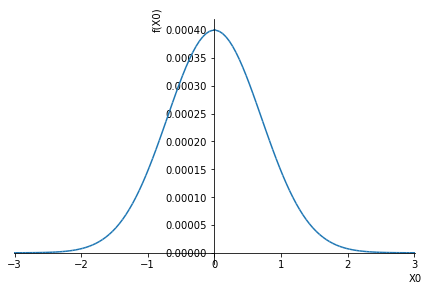

<IPython.core.display.Latex object>

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    23.45      3.26593e+09        5       0.00234327       0.00261775      2.45m
   1     8.35          1360.02        5       0.00127607       0.00122523      2.82m
-------------------------------------------------- INFO --------------------------------------------------
------------------------------ Popupation:700, Stopping Cretia:0.0001
div(abs(0.004), self_exp(X0))
Expression: 0.0004*exp(-X0**2)
-------------------------------------------------- SUBTREE --------------------------------------------------


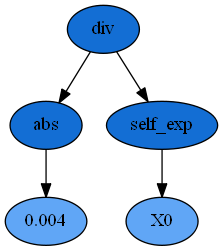

-------------------------------------------------- PROBABILITY --------------------------------------------------


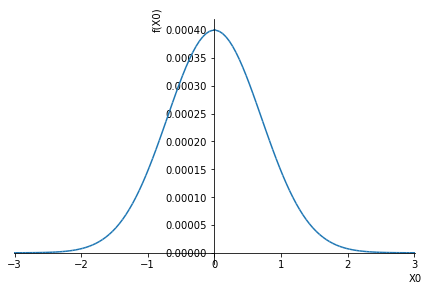

<IPython.core.display.Latex object>

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    23.45      3.26593e+09        5       0.00234327       0.00261775      2.54m
   1     8.35          1360.02        5       0.00127607       0.00122523      2.82m
-------------------------------------------------- INFO --------------------------------------------------
------------------------------ Popupation:700, Stopping Cretia:0.0005
div(abs(0.004), self_exp(X0))
Expression: 0.0004*exp(-X0**2)
-------------------------------------------------- SUBTREE --------------------------------------------------


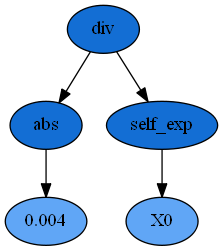

-------------------------------------------------- PROBABILITY --------------------------------------------------


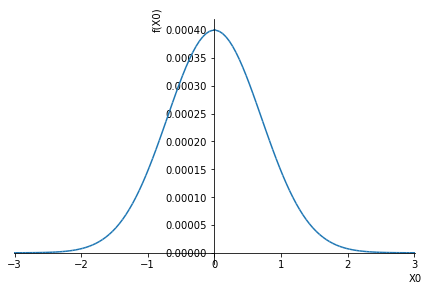

<IPython.core.display.Latex object>

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    23.45      3.26593e+09        5       0.00234327       0.00261775      2.43m
   1     8.35          1360.02        5       0.00127607       0.00122523      2.91m
-------------------------------------------------- INFO --------------------------------------------------
------------------------------ Popupation:700, Stopping Cretia:0.001
div(abs(0.004), self_exp(X0))
Expression: 0.0004*exp(-X0**2)
-------------------------------------------------- SUBTREE --------------------------------------------------


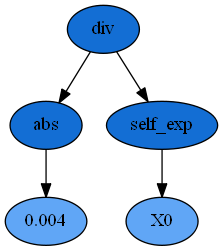

-------------------------------------------------- PROBABILITY --------------------------------------------------


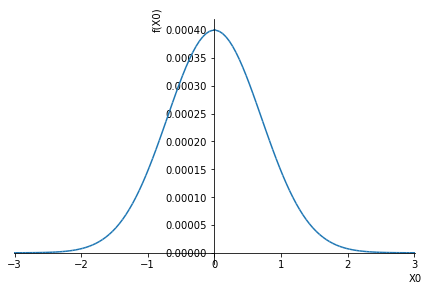

<IPython.core.display.Latex object>

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    23.45      3.26593e+09        5       0.00234327       0.00261775      2.53m
   1     8.35          1360.02        5       0.00127607       0.00122523      2.87m
-------------------------------------------------- INFO --------------------------------------------------
------------------------------ Popupation:700, Stopping Cretia:0.005
div(abs(0.004), self_exp(X0))
Expression: 0.0004*exp(-X0**2)
-------------------------------------------------- SUBTREE --------------------------------------------------


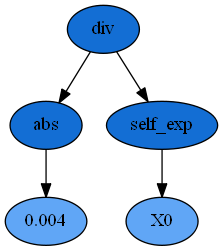

-------------------------------------------------- PROBABILITY --------------------------------------------------


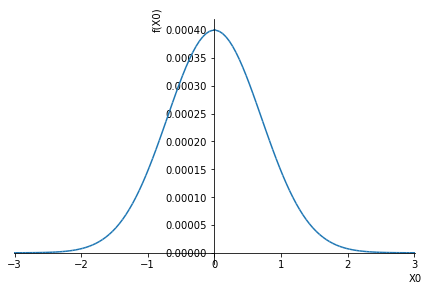

<IPython.core.display.Latex object>

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    23.45      3.26593e+09        5       0.00234327       0.00261775      2.42m
   1     8.35          1360.02        5       0.00127607       0.00122523      2.82m
-------------------------------------------------- INFO --------------------------------------------------
------------------------------ Popupation:700, Stopping Cretia:0.01
div(abs(0.004), self_exp(X0))
Expression: 0.0004*exp(-X0**2)
-------------------------------------------------- SUBTREE --------------------------------------------------


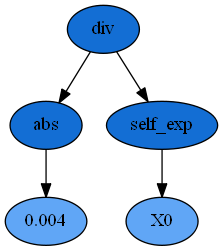

-------------------------------------------------- PROBABILITY --------------------------------------------------


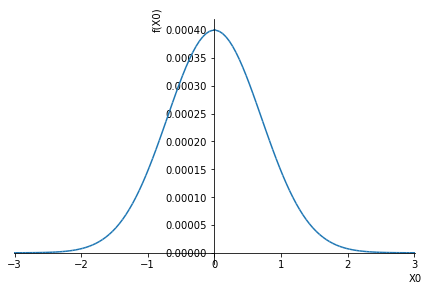

<IPython.core.display.Latex object>

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    23.44      8.76373e+10       39       0.00227317       0.00272417      2.54m
   1     8.29          995.833        5       0.00127607       0.00122523      2.98m
-------------------------------------------------- INFO --------------------------------------------------
------------------------------ Popupation:750, Stopping Cretia:1e-07
div(abs(0.004), self_exp(X0))
Expression: 0.0004*exp(-X0**2)
-------------------------------------------------- SUBTREE --------------------------------------------------


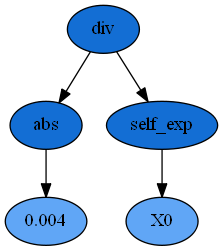

-------------------------------------------------- PROBABILITY --------------------------------------------------


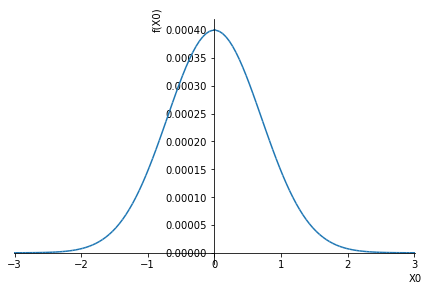

<IPython.core.display.Latex object>

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    23.44      8.76373e+10       39       0.00227317       0.00272417      2.57m
   1     8.29          995.833        5       0.00127607       0.00122523      3.04m
-------------------------------------------------- INFO --------------------------------------------------
------------------------------ Popupation:750, Stopping Cretia:5e-07
div(abs(0.004), self_exp(X0))
Expression: 0.0004*exp(-X0**2)
-------------------------------------------------- SUBTREE --------------------------------------------------


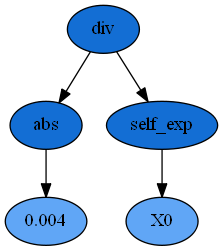

-------------------------------------------------- PROBABILITY --------------------------------------------------


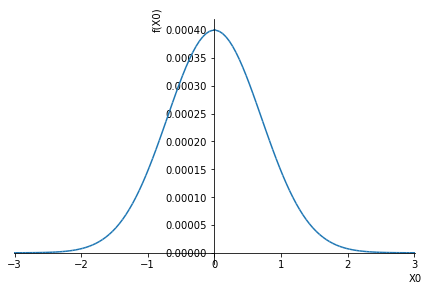

<IPython.core.display.Latex object>

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    23.44      8.76373e+10       39       0.00227317       0.00272417      2.53m
   1     8.29          995.833        5       0.00127607       0.00122523      3.00m
-------------------------------------------------- INFO --------------------------------------------------
------------------------------ Popupation:750, Stopping Cretia:1e-06
div(abs(0.004), self_exp(X0))
Expression: 0.0004*exp(-X0**2)
-------------------------------------------------- SUBTREE --------------------------------------------------


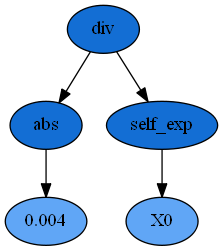

-------------------------------------------------- PROBABILITY --------------------------------------------------


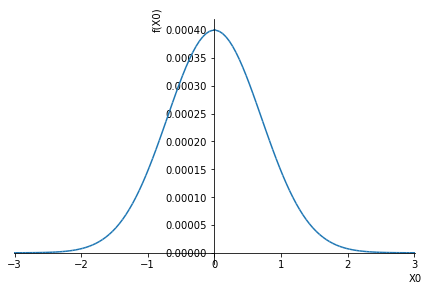

<IPython.core.display.Latex object>

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    23.44      8.76373e+10       39       0.00227317       0.00272417      2.52m
   1     8.29          995.833        5       0.00127607       0.00122523      3.02m
-------------------------------------------------- INFO --------------------------------------------------
------------------------------ Popupation:750, Stopping Cretia:5e-06
div(abs(0.004), self_exp(X0))
Expression: 0.0004*exp(-X0**2)
-------------------------------------------------- SUBTREE --------------------------------------------------


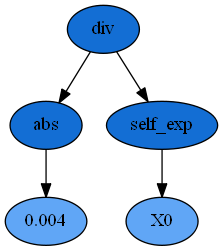

-------------------------------------------------- PROBABILITY --------------------------------------------------


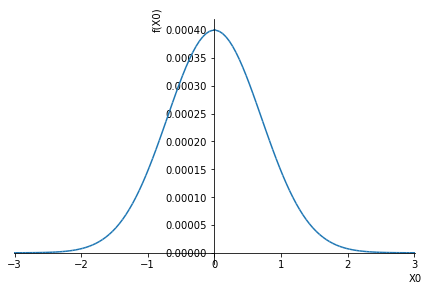

<IPython.core.display.Latex object>

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    23.44      8.76373e+10       39       0.00227317       0.00272417      2.50m
   1     8.29          995.833        5       0.00127607       0.00122523      3.30m
-------------------------------------------------- INFO --------------------------------------------------
------------------------------ Popupation:750, Stopping Cretia:1e-05
div(abs(0.004), self_exp(X0))
Expression: 0.0004*exp(-X0**2)
-------------------------------------------------- SUBTREE --------------------------------------------------


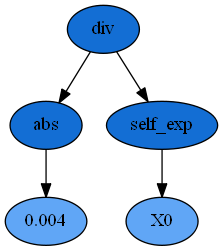

-------------------------------------------------- PROBABILITY --------------------------------------------------


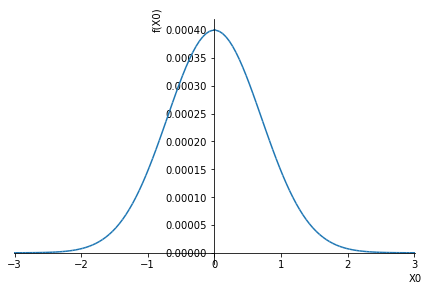

<IPython.core.display.Latex object>

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    23.44      8.76373e+10       39       0.00227317       0.00272417      2.55m
   1     8.29          995.833        5       0.00127607       0.00122523      3.58m
-------------------------------------------------- INFO --------------------------------------------------
------------------------------ Popupation:750, Stopping Cretia:5e-05
div(abs(0.004), self_exp(X0))
Expression: 0.0004*exp(-X0**2)
-------------------------------------------------- SUBTREE --------------------------------------------------


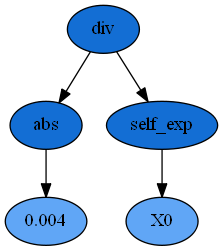

-------------------------------------------------- PROBABILITY --------------------------------------------------


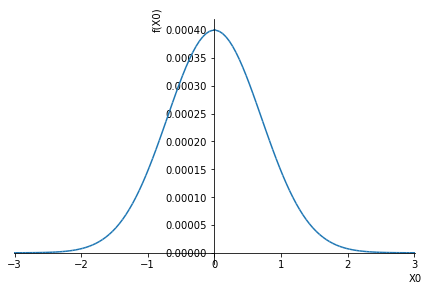

<IPython.core.display.Latex object>

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    23.44      8.76373e+10       39       0.00227317       0.00272417      2.48m
   1     8.29          995.833        5       0.00127607       0.00122523      2.94m
-------------------------------------------------- INFO --------------------------------------------------
------------------------------ Popupation:750, Stopping Cretia:0.0001
div(abs(0.004), self_exp(X0))
Expression: 0.0004*exp(-X0**2)
-------------------------------------------------- SUBTREE --------------------------------------------------


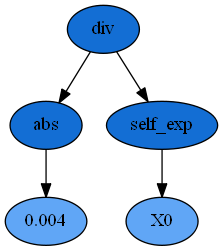

-------------------------------------------------- PROBABILITY --------------------------------------------------


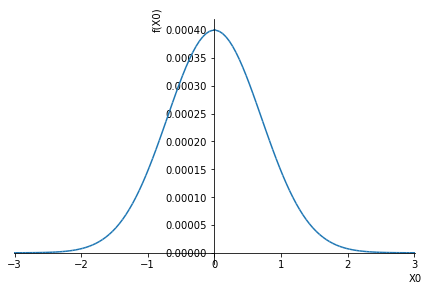

<IPython.core.display.Latex object>

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    23.44      8.76373e+10       39       0.00227317       0.00272417      2.58m
   1     8.29          995.833        5       0.00127607       0.00122523      2.94m
-------------------------------------------------- INFO --------------------------------------------------
------------------------------ Popupation:750, Stopping Cretia:0.0005
div(abs(0.004), self_exp(X0))
Expression: 0.0004*exp(-X0**2)
-------------------------------------------------- SUBTREE --------------------------------------------------


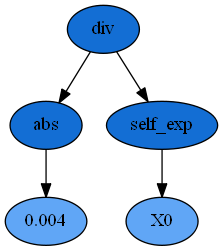

-------------------------------------------------- PROBABILITY --------------------------------------------------


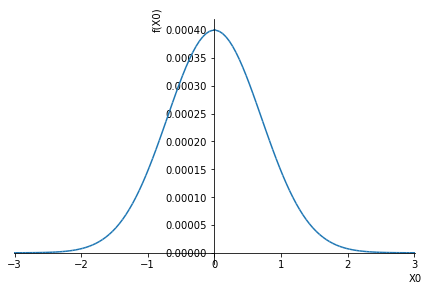

<IPython.core.display.Latex object>

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    23.44      8.76373e+10       39       0.00227317       0.00272417      2.56m
   1     8.29          995.833        5       0.00127607       0.00122523      2.95m
-------------------------------------------------- INFO --------------------------------------------------
------------------------------ Popupation:750, Stopping Cretia:0.001
div(abs(0.004), self_exp(X0))
Expression: 0.0004*exp(-X0**2)
-------------------------------------------------- SUBTREE --------------------------------------------------


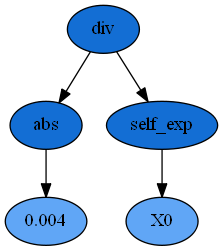

-------------------------------------------------- PROBABILITY --------------------------------------------------


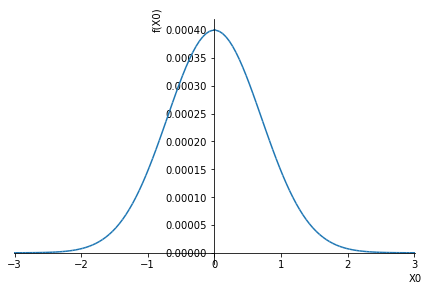

<IPython.core.display.Latex object>

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    23.44      8.76373e+10       39       0.00227317       0.00272417      2.70m
   1     8.29          995.833        5       0.00127607       0.00122523      3.01m
-------------------------------------------------- INFO --------------------------------------------------
------------------------------ Popupation:750, Stopping Cretia:0.005
div(abs(0.004), self_exp(X0))
Expression: 0.0004*exp(-X0**2)
-------------------------------------------------- SUBTREE --------------------------------------------------


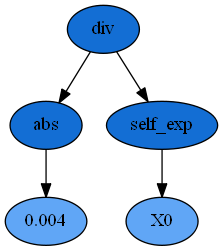

-------------------------------------------------- PROBABILITY --------------------------------------------------


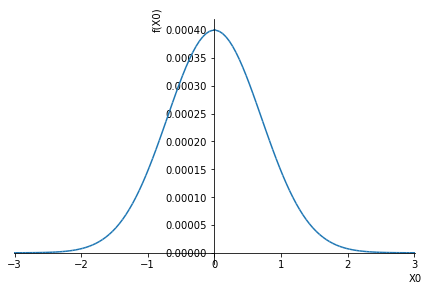

<IPython.core.display.Latex object>

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    23.44      8.76373e+10       39       0.00227317       0.00272417      2.56m
   1     8.29          995.833        5       0.00127607       0.00122523      3.00m
-------------------------------------------------- INFO --------------------------------------------------
------------------------------ Popupation:750, Stopping Cretia:0.01
div(abs(0.004), self_exp(X0))
Expression: 0.0004*exp(-X0**2)
-------------------------------------------------- SUBTREE --------------------------------------------------


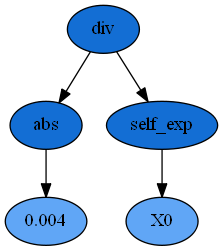

-------------------------------------------------- PROBABILITY --------------------------------------------------


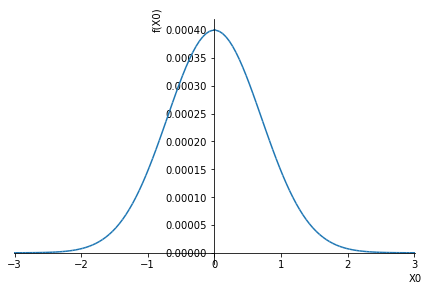

<IPython.core.display.Latex object>

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    23.49      8.21599e+10       39       0.00227317       0.00272417      2.70m
   1     8.11          5944.84        4       0.00142533       0.00158271      3.10m
-------------------------------------------------- INFO --------------------------------------------------
------------------------------ Popupation:800, Stopping Cretia:1e-07
div(0.004, self_exp(X0))
Expression: 0.0004*exp(-X0**2)
-------------------------------------------------- SUBTREE --------------------------------------------------


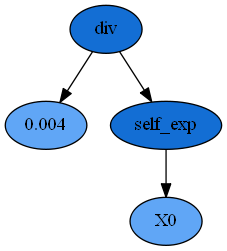

-------------------------------------------------- PROBABILITY --------------------------------------------------


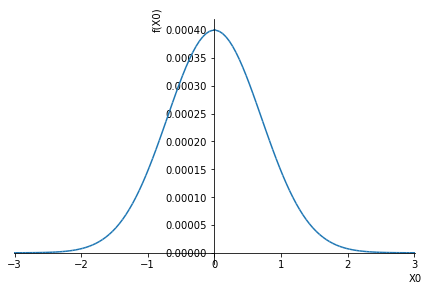

<IPython.core.display.Latex object>

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    23.49      8.21599e+10       39       0.00227317       0.00272417      2.85m
   1     8.11          5944.84        4       0.00142533       0.00158271      3.91m
-------------------------------------------------- INFO --------------------------------------------------
------------------------------ Popupation:800, Stopping Cretia:5e-07
div(0.004, self_exp(X0))
Expression: 0.0004*exp(-X0**2)
-------------------------------------------------- SUBTREE --------------------------------------------------


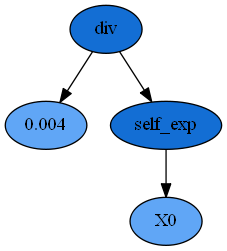

-------------------------------------------------- PROBABILITY --------------------------------------------------


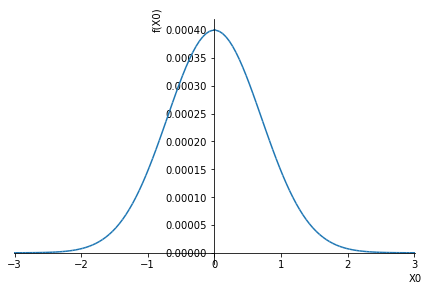

<IPython.core.display.Latex object>

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    23.49      8.21599e+10       39       0.00227317       0.00272417      2.77m
   1     8.11          5944.84        4       0.00142533       0.00158271      3.30m
-------------------------------------------------- INFO --------------------------------------------------
------------------------------ Popupation:800, Stopping Cretia:1e-06
div(0.004, self_exp(X0))
Expression: 0.0004*exp(-X0**2)
-------------------------------------------------- SUBTREE --------------------------------------------------


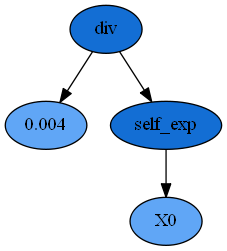

-------------------------------------------------- PROBABILITY --------------------------------------------------


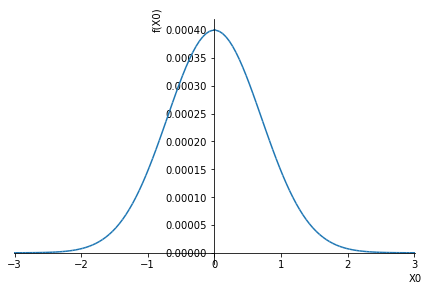

<IPython.core.display.Latex object>

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    23.49      8.21599e+10       39       0.00227317       0.00272417      2.78m
   1     8.11          5944.84        4       0.00142533       0.00158271      3.15m
-------------------------------------------------- INFO --------------------------------------------------
------------------------------ Popupation:800, Stopping Cretia:5e-06
div(0.004, self_exp(X0))
Expression: 0.0004*exp(-X0**2)
-------------------------------------------------- SUBTREE --------------------------------------------------


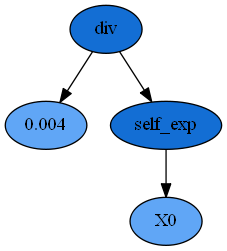

-------------------------------------------------- PROBABILITY --------------------------------------------------


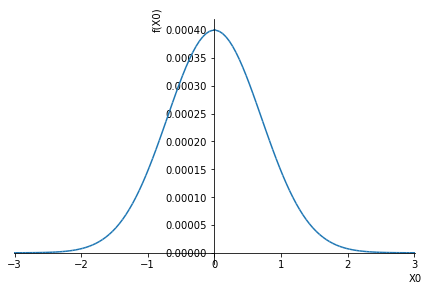

<IPython.core.display.Latex object>

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    23.49      8.21599e+10       39       0.00227317       0.00272417      2.79m
   1     8.11          5944.84        4       0.00142533       0.00158271      3.11m
-------------------------------------------------- INFO --------------------------------------------------
------------------------------ Popupation:800, Stopping Cretia:1e-05
div(0.004, self_exp(X0))
Expression: 0.0004*exp(-X0**2)
-------------------------------------------------- SUBTREE --------------------------------------------------


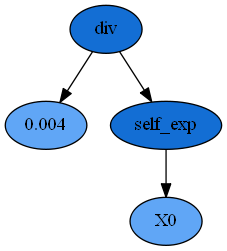

-------------------------------------------------- PROBABILITY --------------------------------------------------


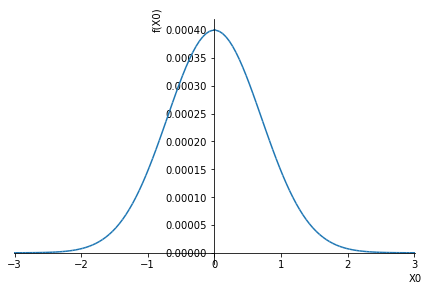

<IPython.core.display.Latex object>

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    23.49      8.21599e+10       39       0.00227317       0.00272417      2.88m


KeyboardInterrupt: 

In [15]:
xdata_1 = xdata / Vm  # Normaliza the data
trans_ratio = 10
prob_data = {'fitted': fit_y, 'theo': f}

# Population list 
pop_list = np.arange(600, 2100, 50)
criteria_list = np.array([1e-7, 5e-7, 1e-6, 5e-6, 1e-5, 5e-5, 1e-4, 5e-4, 0.001, 0.005, 0.01])
# Text the population size
running_info = {}
# per_population = {"Expr":[], 'Inte':[]}
for pop in pop_list:
    name = "Population " + str(pop) 
    running_info[name] = {"Expr":[], 'Inte':[]}
    for creteria in criteria_list:
        symbolic_object = SelfSyblicRegression(xdata_1,
                                           ydata,
                                           population_size=pop,
                                           stopping_criteria=creteria,
                                           transform_ratio=trans_ratio,
                                           const_range=2e-3,
                                           prob_data=prob_data)
        expr_gp = symbolic_object.run() 
        int_value = symbolic_object.calIntegration(expr_gp)
        # per_population['Expr'].append(expr_gp)
        # per_population['Inte'].append(int_value)
        running_info[name]['Expr'].append(expr_gp)
        running_info[name]['Inte'].append(int_value)

# json_str = json.dumps(running_info, indent=4)
# with open('running_info_trangential.json', 'w') as json_file:
#     json_file.write(json_str)


In [ ]:
running_info

In [ ]:
max_list = []
min_list = []

for i in range(600, 2100, 50):
    name = "Population " + str(i)
    pop_info = running_info[name]
    inte_max = np.max(np.array(pop_info['Inte']) - 1)
    inte_min = np.min(np.array(pop_info['Inte'])-1)
    max_list.append(inte_max)
    min_list.append(inte_min)
    print(name,'-'*10, "Max diff: {:.3}, Min diff:{:.3}".format(inte_max, inte_min))

fig = plt.figure(figsize=(12, 9))
plt.plot(range(600, 2100, 50), max_list, label='Maximum Difference')
plt.scatter(range(600, 2100, 50), max_list, c='r')
plt.hlines(0, 600, 2100, colors='orange', linestyles='dashed', label='y=0')
# plt.xticks(range(600, 2100, 50))
plt.legend()
plt.show()


From the data analysis, we found that the best performance happening at the generation of around 1100, and the integration value is 1.05407 that is generated by the symbolic expression as follows,
$$
f = 0.0008981 \times \mathrm{exp}(-x^2)
$$
where $x$ is the normalized velocity. Compared to the theoretical value, the maximum of the difference around 5 %, which is acceptable for me. But as for the constraint, I don't think we should add strict constraint, because strict one does not make sense for symbolic regression due to small error when calculating and memory the data.  

In [ ]:
# <!-- # self-made function -->
def _protected_division(x1, x2):
    """Closure of division (x1/x2) for zero denominator."""
    _EPS = 1e-10
    with np.errstate(divide='ignore', invalid='ignore'):
        abs_x2 = np.abs(x2, dtype=np.float64)
        return np.where(
            np.abs(x2) > _EPS, np.divide(x1, x2),
            np.sign(x2) * np.divide(x1, abs_x2 + _EPS))


def _protectedExp(x):
    """
    Clourse of exp for large result.
    """
    # Cm = 662
    with np.errstate(divide='ignore', invalid='ignore'):
        # exp_f = np.exp(x**2 / Cm**2)
        exp_f = np.exp(x**2)
        return np.where(exp_f > 8.9e6, 0, exp_f)


expo_fun = make_function(function=_protectedExp, name='exp', arity=1)
# <!-- # self_div = make_function(function=_protected_division, name='div', arity=2) -->
fun_set = ['add', 'sub', 'mul', 'neg', 'div',
           expo_fun]  # A set constains all the function we would like to fit
const_limit = 1e-2  # Constant limit, one trick to avoid overflow

# <!-- # Symbolic Regression object -->
est_gp = SymbolicRegressor(population_size=2000,
                           function_set=fun_set,
                           generations=600,
                           stopping_criteria=0.0002,
                           const_range=(-const_limit, const_limit),
                           p_crossover=0.7,
                           p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05,
                           p_point_mutation=0.1,
                           max_samples=0.9,
                           verbose=1,
                           parsimony_coefficient=0.01,
                           random_state=0,
                           n_jobs=2,
                           low_memory=True)

# <!-- # Change the data dimension, so that we could feed it into symbolic regression ovject. -->
transform_ratio = 10
X_train_1 = xdata[:, np.newaxis] / Vm
y_train_1 = fit_y*transform_ratio
est_gp.fit(X_train_1, y_train_1)  # Fitting the data

converter = {
    'sub': lambda x, y : x - y,
    'div': lambda x, y : x / y,
    'mul': lambda x, y : x * y,
    'add': lambda x, y : x + y,
    'neg': lambda x    : - x,
    'pow': lambda x, y : x ** y,
    'sin': lambda x    : sympy.sin(x),
    'cos': lambda x    : sympy.cos(x),
    'inv': lambda x    : 1 / x,
    'sqrt': lambda x   : x ** 0.5,
    'exp': lambda x    : sympy.exp(x**2),
    'square': lambda x : x ** 2
} # <!-- # Converter set -->

print('-'*50, 'INFO', '-'*50)
print(est_gp)
print('R2:', est_gp.score(X_test[:, np.newaxis]/Vm, y_test))  # Give estimation score
next_e = sympy.sympify(str(est_gp._program), locals=converter)
print('Expression:', next_e)

### Integrate the expression 
We found that the error is so large. One of the reason is that the constant could not be smaller anymore, and this is the result from closure in gplearn. 

In [ ]:
x = sympy.symbols('X0')
sympy.init_printing(use_unicode=True)

next_e_new = next_e.subs(x, x/Vm) / transform_ratio
# Set the integration limit
lower_limit = -sympy.oo
upper_limit = sympy.oo
int1 = sympy.Integral(next_e_new, (x, lower_limit, upper_limit))
display(Latex(f"$${sympy.latex(int1)} = {sympy.latex(int1.doit())} = {sympy.latex(int1.doit().evalf(6))}$$"))

### Subtree-structured Individual
From the following binary tree, we could see that the function and variables structure of our symbloic regression is really simple at this situation. However, we do not know what the result would be if we using other more sophiscated data.

In [ ]:
graph = est_gp._program.export_graphviz()
graph = pydotplus.graphviz.graph_from_dot_data(graph)
Image(graph.create_png())

### Plot the Symbolic Expression

In [ ]:
symplot(next_e/transform_ratio, xlim=[-3, 3], adaptive=False, nb_of_points=400)

## Comparison between Symbolic Regression and Empirical Data
In this section, we plot four kinds of data in one graph, i.e., empirical data, symbolic regression data, fitted data, and theroretical data. From the graph, it is clearly noticed that the differences between symblic data and theoretical one is going larger when $x$ going to zero, one of the reason could be constant in the symbolic regression is limited to 3 digital displcement and has been rounded. However, symbolic regression fitted to the data really very well even with such differences, where the largest one could be around 15%.

In [ ]:
X0 = sympy.symbols('X0')  # Create the symbols object
x_scale_list = xdata/Vm
est_value = [next_e.subs({X0:value})/transform_ratio for value in x_scale_list] 

# Plot the graph 
fig = plt.figure(figsize=(9, 6))
plt.plot(xdata / Vm, ydata, label='Real data')
plt.plot(xdata / Vm, fit_y, label='Fitted data', linewidth=4.5)
plt.plot(xdata / Vm, f, label='Theoretical data', linewidth=1.5, c='b')
plt.plot(x_scale_list, est_value, label='Symboic Regression data', linewidth=2, c='r')
plt.xlabel('Tangential velocity in x direction', fontdict=font_format)
plt.ylabel('Probability', fontdict=font_format)
plt.title('Velocity distribution of tangential velocity',
          fontdict=title_format)
plt.legend(fontsize=14)

plt.savefig('./figure/diffuse_model_vt_x and symbolic regression data.png')

## Comparison to Conventional Machine Learning
Even we could gain a really good result on training dataset, we did a little terrible in our testing set compared to the decession tree and random forest tree methods. For this part, I am not going to spend much time on it due to the non-importance for our project.

In [ ]:
# Create conventional regression object
est_tree = DecisionTreeRegressor()
est_tree.fit(X_train_1, y_train_1)
est_rf = RandomForestRegressor(n_estimators=10)
est_rf.fit(X_train_1, y_train_1)

b = np.argsort(X_test)
X_test_new = np.array([X_test[i] for i in b])
y_test_new = np.array([y_test[i] for i in b])

X_test_1 = X_test_new[:, np.newaxis]  # Change the dimension

# Predict the data and gain the score
y_gp = est_gp.predict(X_test_1)
score_gp = est_gp.score(X_test_1, y_test)
y_tree = est_tree.predict(X_test_1)
score_tree = est_tree.score(X_test_1, y_test)
y_rf = est_rf.predict(X_test_1) 
score_rf = est_rf.score(X_test_1, y_test)

In [ ]:
fig = plt.figure(figsize=(16, 6))
font_format_title = {'family': 'Times New Roman', 'size': 20}
font_format = {'family': 'Times New Roman', 'size': 16}

info_list = [(y_gp, score_gp, "Symbolic Regressor"),
             (y_tree, score_tree, "Decession Tree"),
             (y_rf, score_rf, 'Random Forest')]

for i, (y, score, title) in enumerate(info_list):
    ax = fig.add_subplot(1, 3, i + 1)
    fig.subplots_adjust(wspace=0.3, hspace=0.3)
    ax.set_xlabel('Velocity', fontdict=font_format)
    ax.set_ylabel('Probability', fontdict=font_format)
    ax.plot(X_test_new/Vm, y, label='Code')
    ax.plot(X_test_new/Vm, y_test_new, label='Orignal')
    ax.text(-3, 0.0009, r"$R^2=\/ %.6f$" % score, fontsize=14)
    plt.title(title, fontdict=font_format_title)
    plt.legend()
plt.show()